In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
fx_rates = pd.read_excel("./Data/FX_ALL_MONTHLY.xlsx", index_col=0)
fx_rates = fx_rates[fx_rates!=0].dropna()
fx_rates.index = pd.to_datetime(fx_rates.index)
fx_rates = fx_rates.sort_index()
equities = pd.read_excel("./Data/MSCI_ALL_LOCAL_MONTHLY.xlsx", index_col=0, sheet_name="Sheet1")
equities = equities.sort_index()
interestrates = pd.read_excel("./Data/3M_INTEREST_RATES_MONTHLY.xlsx", index_col=0).dropna()
interestrates.columns=pd.read_excel("./Data/3M_interest_rates.xlsx").columns
interestrates.index = pd.to_datetime(interestrates.index)
interestrates = interestrates.sort_index()

In [97]:
def excess_equity_returns(equity_returns, stfir):
    #stfir: short-term foreign interest rate (quoted per annum)
    
    # ensure index is sorted
    equity_returns = equity_returns.sort_index()
    stfir = stfir.sort_index()
    
    #ensure index matches
    equity_returns = equity_returns[equity_returns.index.isin(stfir.index)]
    stfir = stfir[stfir.index.isin(equity_returns.index)]
    
    return equity_returns - ((1+stfir)**(1/4)-1)

def excess_currency_returns(r_fx, fi, di):
    # r_fx: exchange rate returns, fi: foreign interest rate, di: domestic interest rate
    # calculate returns by using a 3 month shift
    # Appreciation in the rate means an increase in the value of domestic currency so returns are calculated on inverse
    r_fx = ((1/r_fx.iloc[3:,:].values)/(1/r_fx.iloc[:-3,:]) -1) * 100
    # exclude domestic currency name from fx rate names
    r_fx.columns = [name.replace(di.name, "") for name in r_fx.columns]
    # sort the columns as in the interest rates df
    r_fx = r_fx[fi.columns]
    ans = r_fx + (fi.sub(di, axis="rows"))
    # adjust for domestic currency
    ans[di.name] = 0
    return ans

def sigma_fx_func(r_fx, fi, di):
    # get excess returns
    excess_r = excess_currency_returns(r_fx, fi, di)
    # return their variance-covariance matirx / pandas cov()
    return excess_r.cov()

def fx_hedge_weights():
    pass

def alpha_hedge_weights(alpha_eq, alpha_fx):
    # alpha_eq: expected excess returns for hedged equities, alpha_fx:  currency expected excess returns
    sigma_fx = sigma_fx_func(r_fx, fi, di)
    sigma_fx_inv = np.linalg.pinv(sigma_fx)
    sigma_eqfx = pd.Series({cur:alpha_fx[cur].cov(alpha_eq[cur]) for cur in alpha_fx.columns})
    
    w_hedge = np.matmul(-sigma_fx_inv, sigma_eqfx)
    w_alpha = np.matmul(sigma_fx_inv,alpha_fx.mean())
    
    alpha_minvar = alpha_eq.mean() - np.matmul(alpha_fx.mean(), np.matmul(sigma_eqfx, np.matmul())) # done
    sigma_minvar = alpha_eq.std()**2 - np.matmul(sigma_eqfx.T, np.matmul(sigma_fx_inv, sigma_eqfx)) # done
   
    k_opt = (sigma_minvar**2)/alpha_minvar
    w_opt = w_hedge + np.matmul(k_opt, w_hedge)
    
  
    pass

In [127]:
 w_hedge 

USD    0.388354
EUR    0.357366
GBP   -0.280040
JPY   -0.104130
CAD   -0.449481
AUD    0.298324
CHF    0.000000
dtype: float64

In [125]:
sigma_eqfx

USD   -0.336311
EUR   -1.220775
GBP    1.600970
JPY    1.495521
CAD    2.197088
AUD   -1.783645
CHF    0.000000
dtype: float64

In [30]:
domestic_currency="CHF"
# Calculate Excess Equity returns
# Calculate returns for 3 month holing period in local currencies
eq_returns = equities.rolling(3).agg(lambda x: (x[-1]/x[0]-1)*100)
# Calculate excess returns
alpha_eq = pd.DataFrame(columns=interestrates.columns, index = interestrates.index)
alpha_eq["CHF"] = excess_equity_returns(eq_returns["MXUS Index"], interestrates["CHF"])
alpha_eq["USD"] = excess_equity_returns(eq_returns["MSDLE15 Index"], interestrates["USD"][:-3])
alpha_eq["EUR"] = excess_equity_returns(eq_returns["MSDLUK Index"], interestrates["EUR"][:-3])
alpha_eq["CAD"] = excess_equity_returns(eq_returns["MSDLCA Index"], interestrates["CAD"][:-3])
alpha_eq["GBP"] = excess_equity_returns(eq_returns["MSDLE15 Index"], interestrates["GBP"][:-3])
alpha_eq["JPY"] = excess_equity_returns(eq_returns["MSDLJN Index"], interestrates["JPY"][:-3])
alpha_eq["AUD"] = excess_equity_returns(eq_returns["MSDLAS Index"], interestrates["AUD"][:-3])

In [31]:
# Approximation of average excess returns (of local equity indices)---> this seems wrong there should be a risk premium
print(alpha_eq.sum())
# plotting the cumulative excess returns


CHF    248.664938
USD     25.114200
EUR    -21.702816
GBP     13.684059
JPY    133.050904
CAD    171.569492
AUD     60.717662
dtype: float64


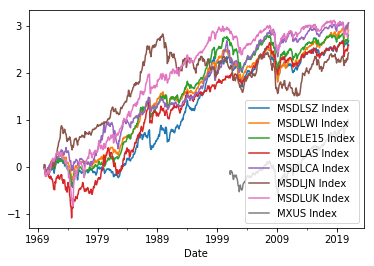

In [491]:
# Cumulative monthly log returns
np.log(1+(equities.pct_change())).cumsum().plot()

In [38]:
# Calculate Excess Currency returns
interestrates = interestrates[interestrates.index.isin(fx_rates.index)]
fx_rates = fx_rates[fx_rates.index.isin(interestrates.index)]
fi = interestrates[[cur for cur in interestrates.columns if cur != domestic_currency ]]
di = interestrates[domestic_currency]
alpha_fx = excess_currency_returns(fx_rates, fi, di)


In [39]:
sigma_eqfx = pd.Series({cur:alpha_fx[cur].cov(alpha_eq[cur]) for cur in alpha_fx.columns}).T

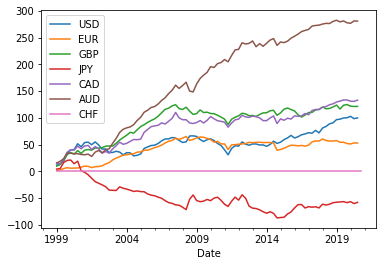

In [44]:
sigma_eqfx

In [65]:
k = np.sqrt( / (alpha_fx.mean().values ))
sigma_fx_inv.multiply(-sigma_eqfx + k * alpha_fx.mean())

,USD,EUR,GBP,JPY,CAD,AUD,CHF
USD,8.182858,3.664299,-18.747867,-19.385535,-35.254984,9.901614,0.0
EUR,1.009477,9.895313,-11.725488,-0.408115,-15.437009,14.324766,0.0
GBP,3.938308,8.940944,-32.023014,-5.145309,-31.953254,22.304945,0.0
JPY,4.359398,0.333139,-5.508107,-43.513936,-15.538885,3.259365,0.0
CAD,5.396524,8.577315,-23.283639,-10.577054,-56.480390,32.431663,0.0
AUD,1.866975,9.804258,-20.020546,-2.732856,-39.949211,51.554498,0.0
CHF,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.0


In [71]:
sigma_eqfx

USD   -0.336311
EUR   -1.220775
GBP    1.600970
JPY    1.495521
CAD    2.197088
AUD   -1.783645
CHF    0.000000
dtype: float64